# Part 5: 2D Rendering and Shading in Python
This notebook demonstrates fundamental 2D graphics operations using Python. We explore how to draw basic primitives (points, lines, triangles), apply geometric transformations (translation, scaling, rotation), and implement triangle rasterization and shading (flat and Gouraud). All operations are performed using NumPy and visualized with Matplotlib.



## 1. Imports and Configuration

We begin by importing essential libraries and defining screen-related parameters:

- The screen resolution is fixed to 100x100 pixels.
- Basic RGB color constants are defined (e.g., RED, GREEN, BLUE, GRAY).
- These constants are used to simulate a pixel-based drawing canvas.


In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Screen setup
SCREEN_WIDTH = 100
SCREEN_HEIGHT = 100

# Colors
RED = [255, 0, 0]
GREEN = [0, 255, 0]
BLUE = [0, 0, 255]
GRAY = [128, 128, 128]

# Part 5: 2D Rendering and Shading in Python

## 2. Transformation Matrices

This section defines reusable functions to create standard 2D transformation matrices in homogeneous coordinates:

- `translation_matrix(tx, ty)` shifts points by (tx, ty).
- `scaling_matrix(sx, sy)` scales points with respect to the origin.
- `rotation_matrix(theta)` rotates points counterclockwise by an angle theta.

These transformations are applied using 3x3 matrices to allow for affine transformations.


In [11]:
def translation_matrix(tx, ty):
    return np.array([[1, 0, tx], [0, 1, ty], [0, 0, 1]])

def scaling_matrix(sx, sy):
    return np.array([[sx, 0, 0], [0, sy, 0], [0, 0, 1]])

def rotation_matrix(theta):
    c = np.cos(theta)
    s = np.sin(theta)
    return np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])

## 3. Drawing Functions

This part implements the foundational drawing functions used in rendering:

- `draw_point(x, y, color, screen)`: draws a single pixel at (x, y).
- `draw_line(x0, y0, x1, y1, color, screen)`: uses Bresenham’s line algorithm to draw lines between points.
- `draw_triangle(p0, p1, p2, color, screen)`: connects three points with lines to render a triangle outline.


In [12]:
def draw_point(x, y, color, screen):
    if 0 <= x < screen.shape[1] and 0 <= y < screen.shape[0]:
        screen[y, x] = color

def draw_line(x0, y0, x1, y1, color, screen):
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy
    while True:
        draw_point(x0, y0, color, screen)
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy

def draw_triangle(p0, p1, p2, color, screen):
    draw_line(p0[0], p0[1], p1[0], p1[1], color, screen)
    draw_line(p1[0], p1[1], p2[0], p2[1], color, screen)
    draw_line(p2[0], p2[1], p0[0], p0[1], color, screen)

def signed_area(a, b, c):
    return (b[0] - a[0]) * (c[1] - a[1]) - (b[1] - a[1]) * (c[0] - a[0])

def fill_triangle(p0, p1, p2, color, screen):
    p0 = np.array(p0, dtype=float)
    p1 = np.array(p1, dtype=float)
    p2 = np.array(p2, dtype=float)
    min_x = int(np.floor(min(p0[0], p1[0], p2[0])))
    max_x = int(np.ceil(max(p0[0], p1[0], p2[0])))
    min_y = int(np.floor(min(p0[1], p1[1], p2[1])))
    max_y = int(np.ceil(max(p0[1], p1[1], p2[1])))
    D = signed_area(p0, p1, p2)
    if D == 0:
        return
    for y in range(max(min_y, 0), min(max_y + 1, SCREEN_HEIGHT)):
        for x in range(max(min_x, 0), min(max_x + 1, SCREEN_WIDTH)):
            p = np.array([x, y], dtype=float)
            alpha = signed_area(p, p1, p2) / D
            beta = signed_area(p0, p, p2) / D
            gamma = signed_area(p0, p1, p) / D
            if alpha >= 0 and beta >= 0 and gamma >= 0:
                screen[y, x] = color

def fill_triangle_gouraud(p0, p1, p2, c0, c1, c2, screen):
    p0 = np.array(p0, dtype=float)
    p1 = np.array(p1, dtype=float)
    p2 = np.array(p2, dtype=float)
    c0 = np.array(c0, dtype=float)
    c1 = np.array(c1, dtype=float)
    c2 = np.array(c2, dtype=float)
    min_x = int(np.floor(min(p0[0], p1[0], p2[0])))
    max_x = int(np.ceil(max(p0[0], p1[0], p2[0])))
    min_y = int(np.floor(min(p0[1], p1[1], p2[1])))
    max_y = int(np.ceil(max(p0[1], p1[1], p2[1])))
    D = signed_area(p0, p1, p2)
    if D == 0:
        return
    for y in range(max(min_y, 0), min(max_y + 1, SCREEN_HEIGHT)):
        for x in range(max(min_x, 0), min(max_x + 1, SCREEN_WIDTH)):
            p = np.array([x, y], dtype=float)
            alpha = signed_area(p, p1, p2) / D
            beta = signed_area(p0, p, p2) / D
            gamma = signed_area(p0, p1, p) / D
            if alpha >= 0 and beta >= 0 and gamma >= 0:
                color = alpha * c0 + beta * c1 + gamma * c2
                screen[y, x] = np.clip(color, 0, 255).astype(np.uint8)

def transform_point(point, matrix):
    p = np.array([point[0], point[1], 1], dtype=float)
    transformed = matrix @ p
    return np.round(transformed[:2]).astype(int)

## 4. Gouraud Shading

In this section, we implement Gouraud shading using barycentric interpolation.

- `fill_triangle(...)` fills a triangle uniformly using a single color.
- `fill_triangle_gouraud(...)` interpolates RGB values from each vertex across the triangle surface to achieve smooth shading.
- Barycentric coordinates are used to determine if a pixel lies within the triangle and to blend vertex colors proportionally.


In [13]:

# Define triangle vertices
p0 = [50, 60]
p1 = [60, 40]
p2 = [40, 40]


## 5. Transform Utility

The `transform_point(point, matrix)` function applies a 3x3 transformation matrix to a 2D point using homogeneous coordinates. This utility allows geometric transformations to be applied consistently across points and shapes.


## 5.1 Basic Rendering Primitives

We begin by rendering the simplest graphical elements:

- A single red point at a fixed location.
- A green diagonal line.
- A blue triangle outline defined by three vertex positions.

These primitives demonstrate pixel-level control over rendering.


In [14]:

# 5.1 Basic Rendering Primitives
screen_primitives = np.zeros((SCREEN_HEIGHT, SCREEN_WIDTH, 3), dtype=np.uint8)
draw_point(50, 50, RED, screen_primitives)
draw_line(20, 20, 80, 80, GREEN, screen_primitives)
draw_triangle(p0, p1, p2, BLUE, screen_primitives)

plt.savefig('rendering_output.png')

<Figure size 640x480 with 0 Axes>

## 5.2 Transformations

This section applies geometric transformations to the initial triangle:

- Translation: shifts the triangle horizontally.
- Scaling: enlarges the triangle.
- Rotation: rotates the triangle around the origin.

Each transformation is implemented via matrix multiplication, and the transformed triangle is filled in red.


In [15]:

# 5.2 Transformations
screen_trans = np.zeros((SCREEN_HEIGHT, SCREEN_WIDTH, 3), dtype=np.uint8)
screen_scale = np.zeros((SCREEN_HEIGHT, SCREEN_WIDTH, 3), dtype=np.uint8)
screen_rotate = np.zeros((SCREEN_HEIGHT, SCREEN_WIDTH, 3), dtype=np.uint8)

matrices = {
    'Translation': translation_matrix(20, 0),
    'Scaling': scaling_matrix(1.5, 1.5),
    'Rotation': rotation_matrix(np.pi / 4)  # 45 degrees
}
screens = [screen_trans, screen_scale, screen_rotate]

for screen, (title, matrix) in zip(screens, matrices.items()):
    draw_triangle(p0, p1, p2, BLUE, screen)
    p0_t = transform_point(p0, matrix)
    p1_t = transform_point(p1, matrix)
    p2_t = transform_point(p2, matrix)
   

## 5.3 Rasterization

Here, the triangle is filled using a uniform color (solid red), demonstrating the process of converting geometric primitives into pixel-based representations. Barycentric coordinates are used to test whether each pixel falls inside the triangle.


In [16]:

# 5.3 Rasterization
screen_raster = np.zeros((SCREEN_HEIGHT, SCREEN_WIDTH, 3), dtype=np.uint8)
fill_triangle(p0, p1, p2, RED, screen_raster)

## 5.4 Shading Techniques

This section compares two shading methods:

- Flat shading: fills the triangle with a single gray color, producing a uniform appearance.
- Gouraud shading: interpolates the red, green, and blue vertex colors across the triangle to produce a gradient.

The difference illustrates how shading models affect visual realism.


In [17]:

# 5.4 Shading
screen_flat = np.zeros((SCREEN_HEIGHT, SCREEN_WIDTH, 3), dtype=np.uint8)
screen_gouraud = np.zeros((SCREEN_HEIGHT, SCREEN_WIDTH, 3), dtype=np.uint8)
fill_triangle(p0, p1, p2, GRAY, screen_flat)
fill_triangle_gouraud(p0, p1, p2, RED, GREEN, BLUE, screen_gouraud)


## 6. Visualization

All rendering outputs are displayed using Matplotlib.

- Multiple rendering stages (primitives, transformations, rasterization, and shading) are shown side-by-side for comparison.
- An additional plot displays the result of Gouraud shading alone for closer inspection.


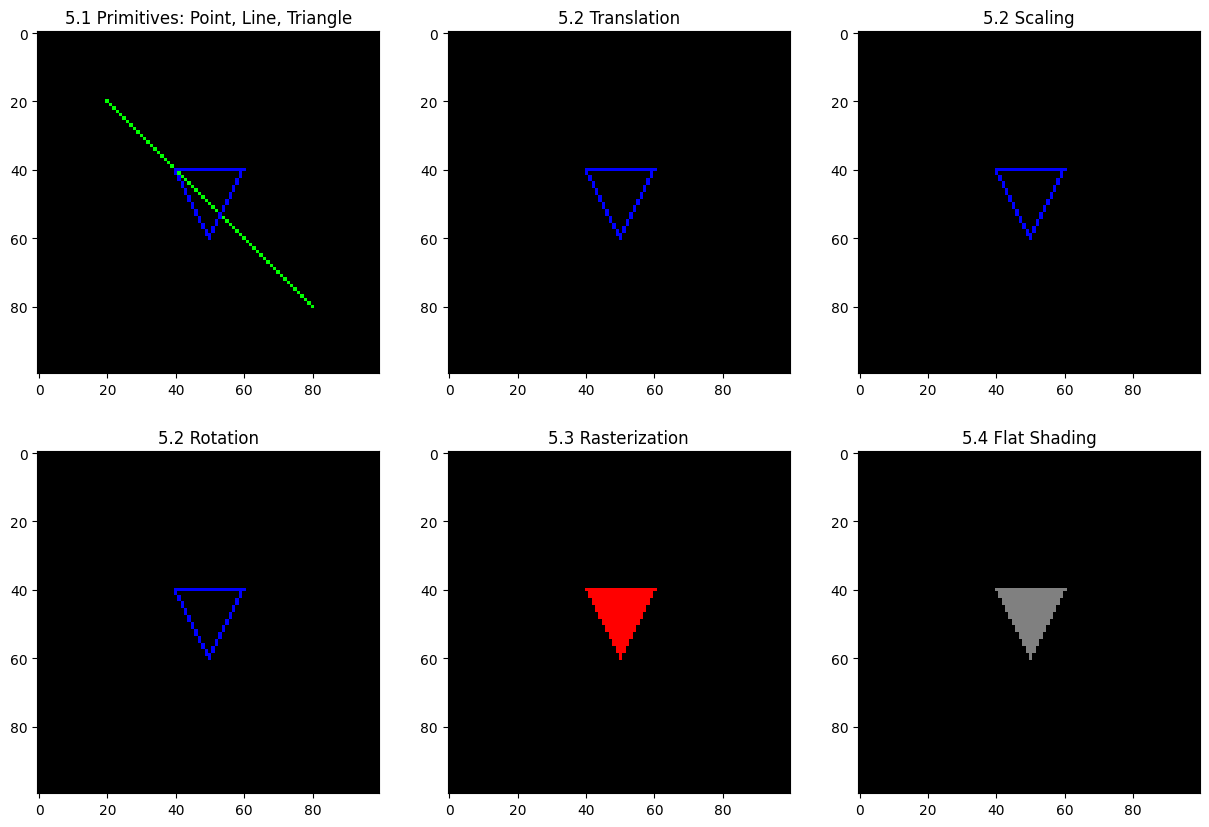

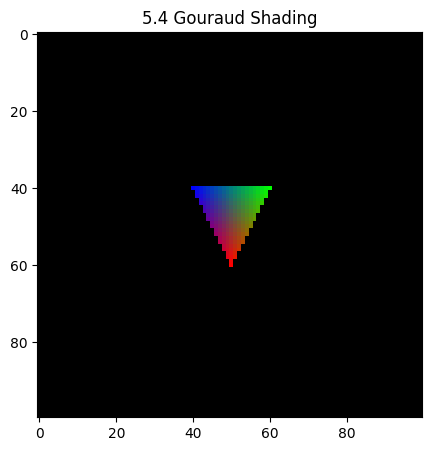

In [18]:

# Display results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes[0, 0].imshow(screen_primitives)
axes[0, 0].set_title('5.1 Primitives: Point, Line, Triangle')
axes[0, 1].imshow(screen_trans)
axes[0, 1].set_title('5.2 Translation')
axes[0, 2].imshow(screen_scale)
axes[0, 2].set_title('5.2 Scaling')
axes[1, 0].imshow(screen_rotate)
axes[1, 0].set_title('5.2 Rotation')
axes[1, 1].imshow(screen_raster)
axes[1, 1].set_title('5.3 Rasterization')
axes[1, 2].imshow(screen_flat)
axes[1, 2].set_title('5.4 Flat Shading')
plt.figure(figsize=(5, 5))
plt.imshow(screen_gouraud)
plt.title('5.4 Gouraud Shading')
plt.savefig('rendering_output.png')